In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import math
import time
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, average_precision_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def get_auc_from_clf(clf, X, Y, score_fn):
    pred = clf.predict_proba(X)[:,1]
    return score_fn(Y, pred)

def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan

    try:
      score = actual_scorer(y_true, y_pred)
    except Exception: 
      pass

    return score

def save_to_pickle(data, filename):
    with open(filename, 'wb') as fp:
        pickle.dump(data, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_from_pickle(filename):
    with open(filename, 'rb') as fp:
        data = pickle.load(fp)
    return data

In [3]:
seed = 35
# metric = 'aucroc'
# score_fn = roc_auc_score
metric = 'aucprc'
score_fn = average_precision_score
auc_score = make_scorer(custom_scorer, actual_scorer = score_fn, needs_threshold=True)
scoring = {metric: auc_score}

In [4]:
folder1 = 'dataset1'
folder2 = 'dataset2'

In [5]:
trainval_df1 = pd.read_csv(f'{folder1}/processed_trainval_data.csv')
display(trainval_df1.shape)
display(trainval_df1.head())
trainval_df2 = pd.read_csv(f'{folder2}/processed_trainval_data.csv')
display(trainval_df2.shape)
display(trainval_df2.head())

(1552, 28)

,X_Minimum,Square_Index,Length_of_Conveyer,Y_Perimeter,Edges_Y_Index,Maximum_of_Luminosity,X_Perimeter,Orientation_Index,Luminosity_Index,Empty_Index,Log_Y_Index,Outside_Global_Index,Minimum_of_Luminosity,Outside_X_Index,Edges_X_Index,Steel_Plate_Thickness,Y_Maximum,Edges_Index,Pixels_Areas,SigmoidOfAreas,LogOfAreas,Sum_of_Luminosity,TypeOfSteel_A400,TypeOfSteel_A300,Y_Minimum,Log_X_Index,X_Maximum,label
0,0.557185,0.579812,0.234568,0.000606,1.000000,0.481481,0.000670,0.709991,0.585558,0.264859,0.253411,1.0,0.566502,0.004231,0.774554,0.519231,0.065121,0.595458,0.000400,0.079682,0.306859,0.000648,1.0,0.0,0.065121,0.196206,0.557636,0
1,0.000000,0.109307,0.231041,0.006556,1.000000,0.259259,0.008711,0.945327,0.352651,0.547410,0.488224,1.0,0.251232,0.010064,0.138088,0.115385,0.051667,0.000000,0.005306,0.999886,0.534254,0.005177,0.0,1.0,0.051659,0.304749,0.005851,0
2,0.024047,0.955430,0.305115,0.025784,0.336801,0.490741,0.072174,0.477531,0.552651,0.521665,0.525512,0.0,0.108374,0.146157,0.228287,0.000000,0.075784,0.058883,0.104118,1.000000,0.798800,0.159364,1.0,0.0,0.075772,0.705600,0.127560,0
3,0.022874,0.973480,0.308642,0.017024,0.464376,0.490741,0.047669,0.513088,0.553870,0.432673,0.512316,1.0,0.152709,0.119053,0.285714,0.000000,0.113532,0.055868,0.087172,1.000000,0.782989,0.133714,1.0,0.0,0.113521,0.674083,0.107080,0
4,0.687977,0.573359,0.222222,0.001377,1.000000,0.393519,0.001723,0.713219,0.492566,0.358618,0.332261,1.0,0.379310,0.010979,0.746347,0.038462,0.082096,0.245076,0.001677,0.593871,0.432261,0.002284,0.0,1.0,0.082095,0.315567,0.692803,0


(1178, 22)

,media_exposure,wife_religion,num_children_born,wife_working,wife_age,wife_education_1,wife_education_2,wife_education_3,wife_education_4,husband_education_1,husband_education_2,husband_education_3,husband_education_4,husband_occupation_1,husband_occupation_2,husband_occupation_3,husband_occupation_4,standard_of_living_index_1,standard_of_living_index_2,standard_of_living_index_3,standard_of_living_index_4,label
0,0,0,2,1,28,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1,1,1,0,27,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,0,1,2,1,28,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,0,1,3,1,24,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,0,0,4,1,35,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [6]:
test_df1 = pd.read_csv(f'{folder1}/processed_test_data.csv')
display(test_df1.shape)
display(test_df1.head())
test_df2 = pd.read_csv(f'{folder2}/processed_test_data.csv')
display(test_df2.shape)
display(test_df2.head())

(389, 28)

,X_Minimum,Square_Index,Length_of_Conveyer,Y_Perimeter,Edges_Y_Index,Maximum_of_Luminosity,X_Perimeter,Orientation_Index,Luminosity_Index,Empty_Index,Log_Y_Index,Outside_Global_Index,Minimum_of_Luminosity,Outside_X_Index,Edges_X_Index,Steel_Plate_Thickness,Y_Maximum,Edges_Index,Pixels_Areas,SigmoidOfAreas,LogOfAreas,Sum_of_Luminosity,TypeOfSteel_A400,TypeOfSteel_A300,Y_Minimum,Log_X_Index,X_Maximum,label
0,0.344868,0.887970,0.746032,0.000441,1.000000,0.416667,0.000766,0.555858,0.539732,0.250132,0.224059,1.0,0.472906,0.003888,0.797078,0.115385,0.134446,0.716137,0.000347,0.066175,0.294796,0.000517,0.0,1.0,0.134447,0.217122,0.346401,0
1,0.026979,0.404154,0.234568,0.005344,0.528163,0.439815,0.018666,0.201796,0.497867,0.445598,0.406791,0.0,0.182266,0.109332,0.665280,0.000000,0.014071,0.067926,0.027042,1.000000,0.678928,0.037291,1.0,0.0,0.014068,0.656161,0.101814,0
2,0.059238,0.928002,0.700176,0.000716,1.000000,0.416667,0.001532,0.535835,0.511883,0.244517,0.269120,1.0,0.443350,0.007434,0.718141,0.115385,0.112502,0.125000,0.000904,0.216459,0.377885,0.001279,0.0,1.0,0.112502,0.293138,0.064365,0
3,0.078592,0.246647,0.227513,0.005124,0.921711,0.402778,0.008806,0.876633,0.515174,0.623795,0.455421,1.0,0.463054,0.016812,0.222808,0.115385,0.031199,0.198553,0.005142,1.000000,0.531468,0.007335,0.0,1.0,0.031193,0.375536,0.088941,0
4,0.357771,1.000000,0.282187,0.000826,0.934321,0.416667,0.001244,0.499823,0.552834,0.249603,0.276164,0.5,0.497537,0.010636,1.000000,0.000000,0.040238,0.883842,0.001114,0.289444,0.396195,0.001704,1.0,0.0,0.040238,0.315567,0.363370,0


(295, 22)

,media_exposure,wife_religion,num_children_born,wife_working,wife_age,wife_education_1,wife_education_2,wife_education_3,wife_education_4,husband_education_1,husband_education_2,husband_education_3,husband_education_4,husband_occupation_1,husband_occupation_2,husband_occupation_3,husband_occupation_4,standard_of_living_index_1,standard_of_living_index_2,standard_of_living_index_3,standard_of_living_index_4,label
0,0,1,7,0,34,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,0,1,1,0,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,1,1,10,1,41,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0,1,6,0,47,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
4,0,1,3,1,40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [7]:
features1 = list(set(trainval_df1.columns) - set(['label']))
label1 = ['label']
trainval_X1 = trainval_df1[features1]
trainval_Y1 = trainval_df1[label1]
test_X1 = test_df1[features1]
test_Y1 = test_df1[label1]

features2 = list(set(trainval_df2.columns) - set(['label']))
label2 = ['label']
trainval_X2 = trainval_df2[features2]
trainval_Y2 = trainval_df2[label2]
test_X2 = test_df2[features2]
test_Y2 = test_df2[label2]

In [8]:
# train_X1, val_X1, train_Y1, val_Y1 = train_test_split(trainval_X1, trainval_Y1, random_state=seed, test_size=0.25)
# train_X2, val_X2, train_Y2, val_Y2 = train_test_split(trainval_X2, trainval_Y2, random_state=seed, test_size=0.25)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(trainval_X1, trainval_Y1)
for train_index, test_index in sss.split(trainval_X1, trainval_Y1):
    train_X1, val_X1 = trainval_X1.iloc[train_index], trainval_X1.iloc[test_index]
    train_Y1, val_Y1 = trainval_Y1.iloc[train_index], trainval_Y1.iloc[test_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(trainval_X2, trainval_Y2)
for train_index, test_index in sss.split(trainval_X2, trainval_Y2):
    train_X2, val_X2 = trainval_X2.iloc[train_index], trainval_X2.iloc[test_index]
    train_Y2, val_Y2 = trainval_Y2.iloc[train_index], trainval_Y2.iloc[test_index]

In [9]:
train_X1.reset_index(drop=True,inplace=True)
val_X1.reset_index(drop=True,inplace=True)
train_Y1.reset_index(drop=True,inplace=True)
val_Y1.reset_index(drop=True,inplace=True)

train_X2.reset_index(drop=True,inplace=True)
val_X2.reset_index(drop=True,inplace=True)
train_Y2.reset_index(drop=True,inplace=True)
val_Y2.reset_index(drop=True,inplace=True)

### hyperparameters tuning for performance comparison across algorithms

In [10]:
learner_dict = {'test_auc': [], 'fit_time': [], 'pred_time': []}
randm_search_res = []
final_clfs = []
for idx, (ds_idx, trainval_X, trainval_Y, test_X, test_Y) in enumerate(zip(['ds1', 'ds2'], 
                                                              [trainval_X1, trainval_X2], [trainval_Y1, trainval_Y2],
                                                              [test_X1, test_X2], [test_Y1, test_Y2])):
    
    dt_params = load_from_pickle(f'{ds_idx}_DT_params.pkl')
    base_estimator = DecisionTreeClassifier(random_state=seed, **dt_params)
    clf = AdaBoostClassifier(base_estimator=base_estimator,
                             random_state=seed)
    parameters = {'n_estimators': sp_randInt(10,100),
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1]}
    randm = RandomizedSearchCV(estimator=clf, param_distributions = parameters,
                               scoring=scoring, refit=metric,
                               cv = 5, n_iter = 100, n_jobs=-1, random_state=seed)
    randm.fit(trainval_X, trainval_Y.label)

    print("\n========================================================")
    print(" Results from Random Search " )
    print("========================================================")
    print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
    print("\n The best valid score across ALL searched params:\n",
          randm.best_score_)
    print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
    print("\n ========================================================")

    final_clf = randm.best_estimator_
    test_auc = get_auc_from_clf(final_clf, test_X, test_Y, score_fn)
    print(f'\nThe best test score after hyperparameter search is {test_auc}')
    learner_dict['test_auc'].append(test_auc)
    randm_search_res.append(randm)
    final_clfs.append(final_clf)



 Results from Random Search 

 The best estimator across ALL searched params:
 AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0002618376447999395,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=43,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=3,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
      

### Wall clock time for dataset1 and dataset2

In [11]:
for idx, (ds_idx, train_X, train_Y, test_X, test_Y) in enumerate(zip(['ds1', 'ds2'],
                                                     [train_X1, train_X2],
                                                     [train_Y1, train_Y2],
                                                     [test_X1, test_X2],
                                                     [test_Y1, test_Y2])):
    
    dt_params = load_from_pickle(f'{ds_idx}_DT_params.pkl')
    base_estimator = DecisionTreeClassifier(random_state=seed, **dt_params)
    best_params = randm_search_res[idx].best_params_
    clf = AdaBoostClassifier(base_estimator=base_estimator,
                             random_state=seed,
                             **best_params)
    start_time = time.time()
    clf.fit(train_X, train_Y.label)
    time_taken = round(time.time() - start_time, 4)
    print(f'Training {ds_idx} took {time_taken} seconds of wall clock time')
    learner_dict['fit_time'].append(time_taken)
    
    start_time = time.time()
    pred = clf.predict_proba(test_X)[:,1]
    time_taken = round(time.time() - start_time, 4)
    print(f'Testing {ds_idx} took {time_taken} seconds of wall clock time')
    learner_dict['pred_time'].append(time_taken)

Training ds1 took 0.3418 seconds of wall clock time
Testing ds1 took 0.0038 seconds of wall clock time
Training ds2 took 0.1182 seconds of wall clock time
Testing ds2 took 0.0052 seconds of wall clock time


In [12]:
save_to_pickle(learner_dict, 'boosting_learner.pkl')

### Learning curve analysis

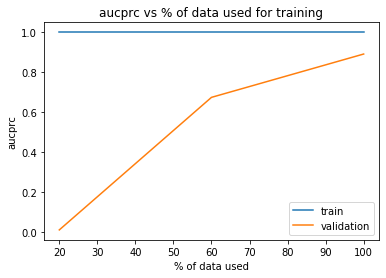

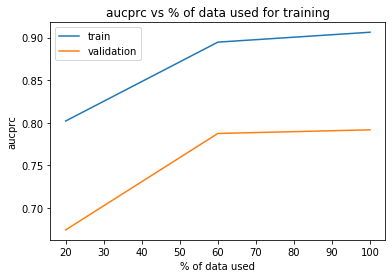

In [13]:
avg_train_auc_dict = {'ds1': [], 'ds2': []}
avg_val_auc_dict = {'ds1': [], 'ds2': []}
data_usages = np.linspace(0.2, 1, num = 3)

for idx, (ds_idx, trainval_X, trainval_Y) in enumerate(zip(['ds1', 'ds2'], 
                                                           [trainval_X1, trainval_X2],
                                                           [trainval_Y1, trainval_Y2])):

    dt_params = load_from_pickle(f'{ds_idx}_DT_params.pkl')
    base_estimator = DecisionTreeClassifier(random_state=seed, **dt_params)
    best_params = randm_search_res[idx].best_params_
    clf = AdaBoostClassifier(base_estimator=base_estimator,
                             random_state=seed,
                             **best_params)
    for data_usage in data_usages:
        temp_X = trainval_X.sample(frac = data_usage, replace=False, random_state=seed)
        temp_Y = trainval_Y.sample(frac = data_usage, replace=False, random_state=seed)
        scores = cross_validate(clf, temp_X, temp_Y.label, scoring=scoring, cv=3, return_train_score=True)

        avg_train_auc_dict[ds_idx].append(np.mean(scores[f'train_{metric}']))
        avg_val_auc_dict[ds_idx].append(np.mean(scores[f'test_{metric}']))

    fig, ax = plt.subplots()
    ax.set_xlabel("% of data used")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs % of data used for training")
    ax.plot(data_usages*100, avg_train_auc_dict[ds_idx], label="train")
    ax.plot(data_usages*100, avg_val_auc_dict[ds_idx], label="validation")
    ax.legend(loc=0)
    plt.show()

### Model complexity analysis

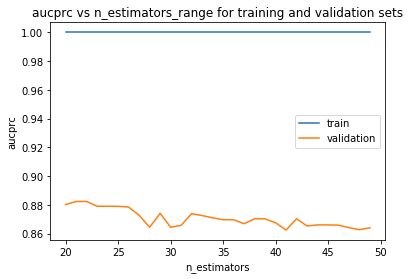

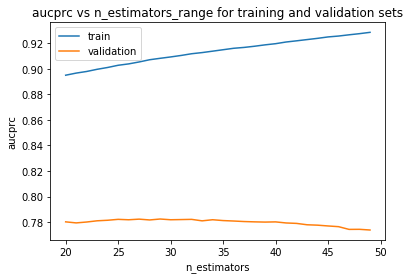

In [14]:
avg_train_auc_dict = {'ds1': [], 'ds2': []}
avg_val_auc_dict = {'ds1': [], 'ds2': []}
n_estimators_range = range(20,50)

for idx, (ds_idx, trainval_X, trainval_Y) in enumerate(zip(['ds1', 'ds2'], 
                                                           [trainval_X1, trainval_X2],
                                                           [trainval_Y1, trainval_Y2])):
    dt_params = load_from_pickle(f'{ds_idx}_DT_params.pkl')
    base_estimator = DecisionTreeClassifier(random_state=seed, **dt_params)
    best_params = randm_search_res[idx].best_params_

    for n_estimators in n_estimators_range:
        best_params['n_estimators'] = n_estimators
        clf = AdaBoostClassifier(base_estimator=base_estimator,
                                 random_state=seed, **best_params)
        scores = cross_validate(clf, trainval_X, trainval_Y.label, scoring=scoring, cv=5, return_train_score=True)
        avg_train_auc_dict[ds_idx].append(np.mean(scores[f'train_{metric}']))
        avg_val_auc_dict[ds_idx].append(np.mean(scores[f'test_{metric}']))
        
    fig, ax = plt.subplots()
    ax.set_xlabel("n_estimators")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs n_estimators_range for training and validation sets")
    ax.plot(n_estimators_range, avg_train_auc_dict[ds_idx], label="train")
    ax.plot(n_estimators_range, avg_val_auc_dict[ds_idx], label="validation")
    ax.legend(loc=0)
    plt.show()

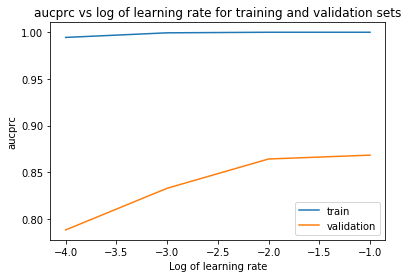

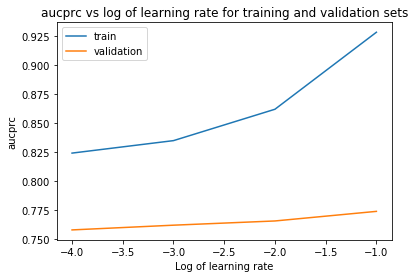

In [18]:
avg_train_auc_dict = {'ds1': [], 'ds2': []}
avg_val_auc_dict = {'ds1': [], 'ds2': []}
learning_rate_range = [0.0001, 0.001, 0.01, 0.1]

for idx, (ds_idx, trainval_X, trainval_Y) in enumerate(zip(['ds1', 'ds2'], 
                                                           [trainval_X1, trainval_X2],
                                                           [trainval_Y1, trainval_Y2])):
    dt_params = load_from_pickle(f'{ds_idx}_DT_params.pkl')
    base_estimator = DecisionTreeClassifier(random_state=seed, **dt_params)
    best_params = randm_search_res[idx].best_params_

    for learning_rate in learning_rate_range:
        best_params['learning_rate'] = learning_rate
        clf = AdaBoostClassifier(base_estimator=base_estimator,
                                 random_state=seed, **best_params)
        scores = cross_validate(clf, trainval_X, trainval_Y.label, scoring=scoring, cv=5, return_train_score=True)
        avg_train_auc_dict[ds_idx].append(np.mean(scores[f'train_{metric}']))
        avg_val_auc_dict[ds_idx].append(np.mean(scores[f'test_{metric}']))
        
    fig, ax = plt.subplots()
    ax.set_xlabel("Log of learning rate")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs log of learning rate for training and validation sets")
    log_learning_rate_range = list(map(lambda x: math.log10(x), learning_rate_range))
    ax.plot(log_learning_rate_range, avg_train_auc_dict[ds_idx], label="train")
    ax.plot(log_learning_rate_range, avg_val_auc_dict[ds_idx], label="validation")
    ax.legend(loc=0)
    plt.show()